# Weakly supervised segmentation experiment

In this experiment we will train a UNET model on the [ISPRS Vaihingen Benchmark dataset](https://www2.isprs.org/commissions/comm2/wg4/benchmark/) using strong supervision (in the form of pixel-level labels) and weak supervision (in the form of hard and soft class-level labels).

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchmetrics

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import ipdb
import pandas as pd

from utils import *
from VaihingenDataset import VaihingenDataset, ToTensor
from UNET import UNET
from ClassLossFN import ClassLossFN

# Dataset

The dataset consists of 33 high-resolution images and segmentation masks. We split the images and masks into square tiles and generate class-level labels. 

In [2]:
IMG_PATH = './dataset/whole/images/top/'
GT_PATH = './dataset/whole/ground_truth/'

TEST_IMG = 'top_mosaic_09cm_area35.tif'

[]

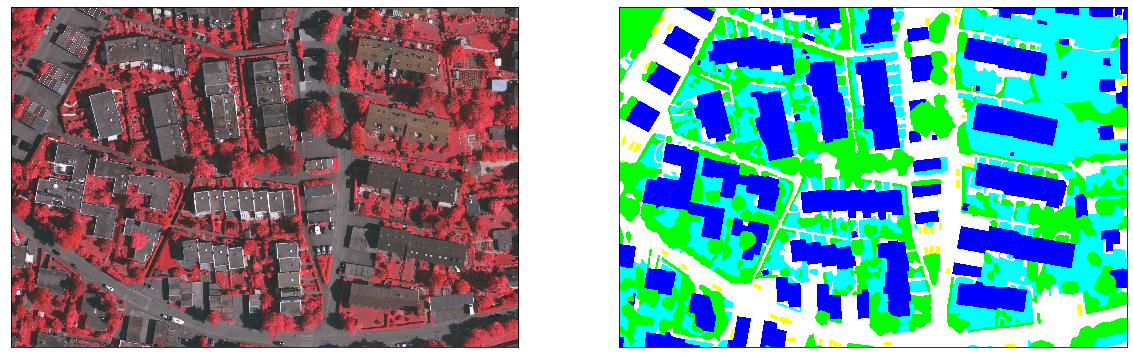

In [4]:
img = io.imread(os.path.join(IMG_PATH, TEST_IMG))
gt = io.imread(os.path.join(GT_PATH, TEST_IMG))

plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots(1,2)

ax[0].imshow(img)
ax[1].imshow(gt)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

In [3]:
# tile width and height (only tested for square tiles)
TILE_W = 192
TILE_H = 192
# stride - higher stride gives smaller overlap between tiles but fewer examples
STRIDE = 50

SAVE_IMG_PATH = './dataset/tiles_{}x{}_s{}/images/'.format(TILE_W, TILE_H, STRIDE)
SAVE_GT_PATH = './dataset/tiles_{}x{}_s{}/ground_truth/'.format(TILE_W, TILE_H, STRIDE)
SAVE_LABELS_HARD_PATH = './dataset/tiles_{}x{}_s{}/labels_hard.csv'.format(TILE_W, TILE_H, STRIDE)
SAVE_LABELS_SOFT_PATH = './dataset/tiles_{}x{}_s{}/labels_soft.csv'.format(TILE_W, TILE_H, STRIDE)

In [4]:
if os.path.isfile(SAVE_LABELS_HARD_PATH):
    print('Dataset already generated.')
else:
    gen_tile_ds(IMG_PATH, GT_PATH, SAVE_IMG_PATH, SAVE_GT_PATH, SAVE_LABELS_HARD_PATH, SAVE_LABELS_SOFT_PATH, tile_w=TILE_W, tile_h=TILE_H, stride=STRIDE)

Dataset already generated.


In [4]:
TILE_PATH = SAVE_IMG_PATH
TILE_GT_PATH = SAVE_GT_PATH
# soft or hard labels can be used
LABELS_FILE = SAVE_LABELS_HARD_PATH

### We split the tiled dataset into 10% strongly labeled examples, 70% weakly labeled examples and 20% validation examples.

In [5]:
STRONG_SUP_PER = 0.1
WEAK_SUP_PER = 0.7

file_list = pd.read_csv(LABELS_FILE)

strong_ds_len = int(STRONG_SUP_PER * len(file_list))
weak_ds_len = int(WEAK_SUP_PER * len(file_list))
valid_ds_len = len(file_list) - strong_ds_len - weak_ds_len

# we split the data in a deterministic way to consistently measure the results
strong_idx = np.asarray(range(0, strong_ds_len))
weak_idx = np.asarray(range(strong_ds_len, strong_ds_len + weak_ds_len))
valid_idx = np.asarray(range(strong_ds_len + weak_ds_len, len(file_list)))

print('Strong labels set size: {}/{}.'.format(strong_ds_len, len(file_list)))
print('Weak labels set size: {}/{}.'.format(weak_ds_len, len(file_list)))
print('Validation set size: {}/{}.'.format(valid_ds_len, len(file_list)))

Strong labels set size: 4373/43737.
Weak labels set size: 30615/43737.
Validation set size: 8749/43737.


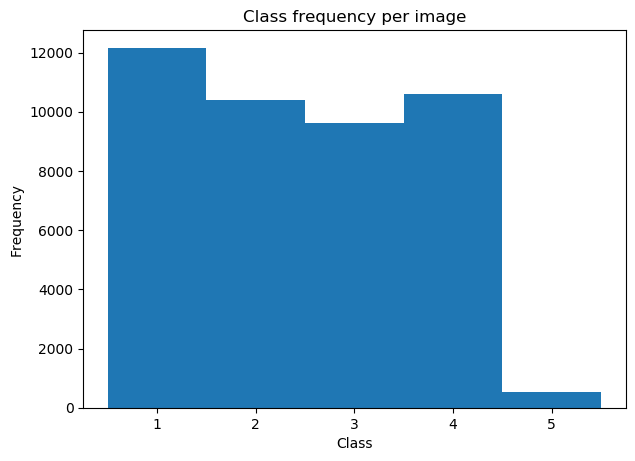

In [11]:
class_freq_per_img = np.array(file_list.iloc[:, 1:]).sum(axis=0)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.bar(list(range(1,6)), class_freq_per_img, 1)

plt.title('Class frequency per image')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [11]:
class_freq_per_pixel = np.zeros(5)
simple_ds = VaihingenDataset(TILE_PATH, TILE_GT_PATH, LABELS_FILE, strong_idx, weak_idx)

for i in strong_idx:
    data_point = simple_ds[i]['ground_truth']
    for j in range(5):
        class_freq_per_pixel[j] += np.count_nonzero(data_point[:, :, j])

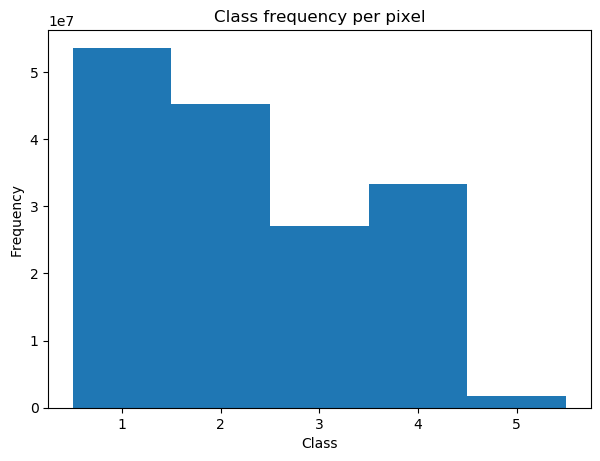

In [12]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.bar(list(range(1,6)), class_freq_per_pixel, 1)

plt.title('Class frequency per pixel')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### Loading the dataset

In [6]:
ds_train_strong = VaihingenDataset(TILE_PATH, TILE_GT_PATH, LABELS_FILE, strong_idx, transform=ToTensor())
ds_train_full = VaihingenDataset(TILE_PATH, TILE_GT_PATH, LABELS_FILE, strong_idx, weak_idx, transform=ToTensor())
ds_valid = VaihingenDataset(TILE_PATH, TILE_GT_PATH, LABELS_FILE, valid_idx, transform=ToTensor())

In [7]:
BATCH_SIZE = 16

strong_dataloader = DataLoader(ds_train_strong, batch_size=BATCH_SIZE)
full_dataloader = DataLoader(ds_train_full, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(ds_valid, batch_size=BATCH_SIZE)

# Training the segmentation model using strong supervision only

In [27]:
LEARNING_RATE = 1e-4

model = UNET()

loss_fn_strong = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [28]:
print(model)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

if torch.cuda.is_available():
    model.cuda()

Using cuda device


In [37]:
MODEL_ID = 'unet_strong_supervision.pth'
SAVED_MODELS_PATH = './saved_models/'
EPOCHS = 3

torch.cuda.empty_cache()

if os.path.isfile(os.path.join(SAVED_MODELS_PATH, MODEL_ID)):
    print('Model already trained.')
else:
    for t in range(EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train(strong_dataloader, model, optimizer, device, loss_fn_strong)
        test(valid_dataloader, model, device, loss_fn_strong)
    print("Done.")
    os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(SAVED_MODELS_PATH, MODEL_ID))

Model already trained.


### Evaluation

In [14]:
saved_model = UNET()
saved_model.load_state_dict(torch.load(os.path.join(SAVED_MODELS_PATH, MODEL_ID)))

<All keys matched successfully>

In [18]:
acc_per_class = get_acc_per_class(saved_model, valid_dataloader, device)

In [20]:
acc_per_class_np = acc_per_class.detach().cpu().numpy()
for i in range(acc_per_class_np.shape[0]):
    print('Accuracy for class {}: {}'.format(i+1, acc_per_class_np[i]))

Accuracy for class 1: 0.5239050766871357
Accuracy for class 2: 0.5297852050184001
Accuracy for class 3: 0.20915116667233313
Accuracy for class 4: 0.520629347583967
Accuracy for class 5: 0.0


### Some example segmentations with the trained model

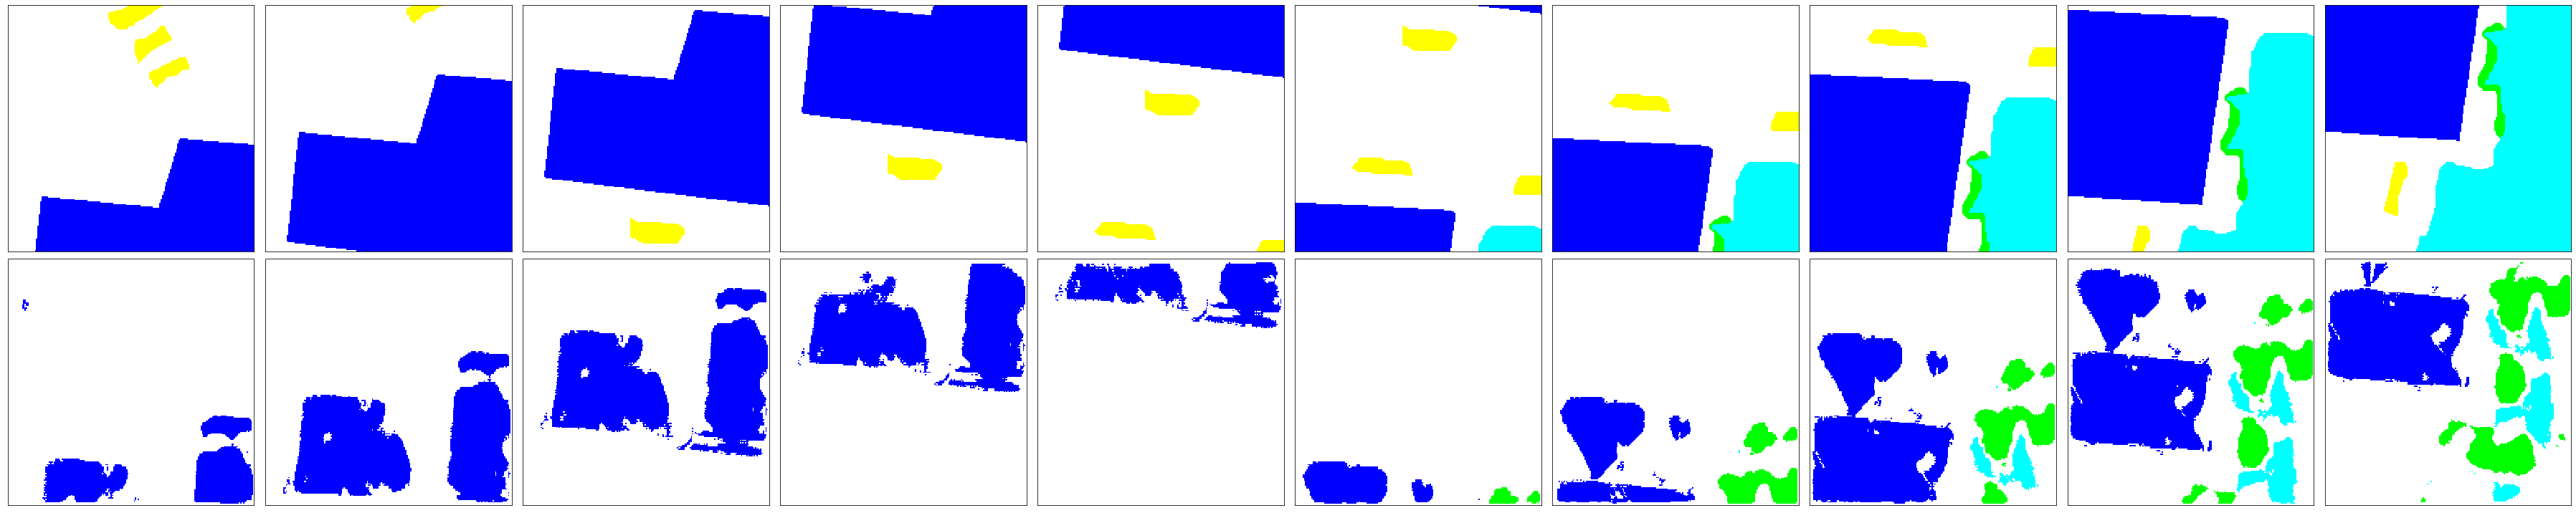

In [16]:
saved_model.to(device)

fig=plt.figure(figsize=(60,10))

columns = 12
rows = 2
num_examples = 10

i = 1
for idx in range(num_examples):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    gt = torch.transpose(ds_valid[idx]['ground_truth'], 0, 2)
    gt = segmap_classes_to_rgb(gt, normalize_key=True)
    plt.imshow(gt)
    fig.add_subplot(rows, columns, columns + i)
    
    model.eval()
    with torch.no_grad():
        pred = saved_model(torch.unsqueeze(ds_valid[idx]['image'], dim=0).cuda())
        pred = (pred > 0.5).float()
    
    plt.xticks([])
    plt.yticks([])
    pred_np = torch.transpose(torch.squeeze(pred.cpu()), 0, 2)
    pred_np = segmap_classes_to_rgb(pred_np, normalize_key=True)
    plt.imshow(pred_np)
    i += 1
        
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# Training the segmentation model using strong and weak supervision

For this part we use an additional loss which computes a class probability vector from the segmentation map and compares with the labels vector.

In [8]:
LEARNING_RATE = 1e-4

model_weak = UNET()

loss_fn_strong = nn.MSELoss()
loss_fn_weak = ClassLossFN()
optimizer_weak = torch.optim.Adam(model_weak.parameters(), lr=LEARNING_RATE)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
if torch.cuda.is_available():
    model_weak.cuda()

Using cuda device


In [38]:
MODEL_WEAK_ID = 'unet_strong_weak_supervision.pth'
SAVED_MODELS_PATH = './saved_models/'
EPOCHS = 1

torch.cuda.empty_cache()

if os.path.isfile(os.path.join(SAVED_MODELS_PATH, MODEL_WEAK_ID)):
    print('Model already trained.')
else:
    for t in range(EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train(full_dataloader, model_weak, optimizer_weak, device, loss_fn_strong, loss_fn_weak)
        test(valid_dataloader, model_weak, device, loss_fn_strong)
    print("Done.")
    os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
    torch.save(model_weak.state_dict(), os.path.join(SAVED_MODELS_PATH, MODEL_WEAK_ID))

Model already trained.


### Evaluation

In [31]:
saved_model_weak = UNET()
saved_model_weak.load_state_dict(torch.load(os.path.join(SAVED_MODELS_PATH, MODEL_WEAK_ID)))

<All keys matched successfully>

In [32]:
acc_per_class = get_acc_per_class(saved_model_weak, valid_dataloader, device)

In [33]:
acc_per_class_np = acc_per_class.detach().cpu().numpy()
for i in range(acc_per_class_np.shape[0]):
    print('Accuracy for class {}: {}'.format(i+1, acc_per_class_np[i]))

Accuracy for class 1: 0.5814688470557356
Accuracy for class 2: 0.7082491426002685
Accuracy for class 3: 0.31612526030950283
Accuracy for class 4: 0.6008927174761889
Accuracy for class 5: 0.0


### Some example segmentations with the trained model

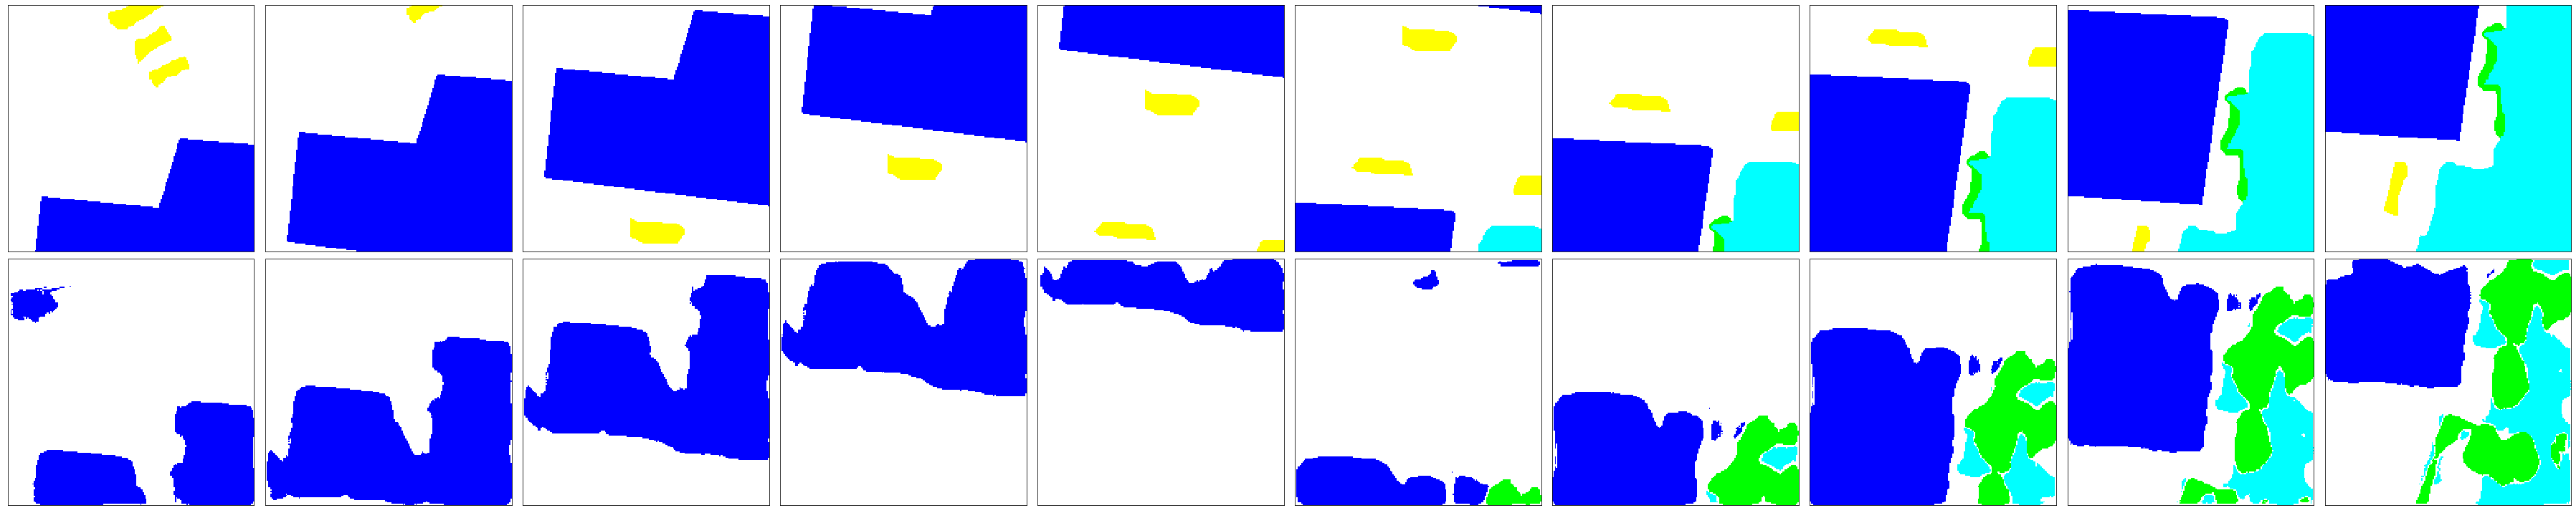

In [34]:
saved_model_weak.to(device)

fig=plt.figure(figsize=(60,10))

columns = 12
rows = 2
num_examples = 10

i = 1
for idx in range(num_examples):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    gt = torch.transpose(ds_valid[idx]['ground_truth'], 0, 2)
    gt = segmap_classes_to_rgb(gt, normalize_key=True)
    plt.imshow(gt)
    fig.add_subplot(rows, columns, columns + i)
    
    with torch.no_grad():
        pred = saved_model_weak(torch.unsqueeze(ds_valid[idx]['image'], dim=0).cuda())
        pred = (pred > 0.5).float()
    
    plt.xticks([])
    plt.yticks([])
    pred_np = torch.transpose(torch.squeeze(pred.cpu()), 0, 2)
    pred_np = segmap_classes_to_rgb(pred_np, normalize_key=True)
    plt.imshow(pred_np)
    i += 1
        
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# Comparison

- we see an improvement in accuracy in every class except class 5; this can be due to the class imbalance, which will be treated in a future iteration

- visually the segmentations are more cohesive, although misclassifications still occur; a more complex model can be used for this task, however due to some hardware limitations a smaller architecture was used

- in this experiment we performed the weakly supervised training in the following way: first we passed the examples which came with strong labels and used both the segmentation and the classification losses to optimize the model, then we passed the examples with only weak labels; the idea behind this is to ensure that the model approaches convergence using the strong loss and any additional learning is done based on the weak loss as an improvement; however it would be interesting to see the results if we sample the strong and weak examples using a different policy (for example randomly)

# Future work

* use regularization
* try a more complex architecture
* implement a loss function that accounts for the class imbalances or augment underrepresented classes
* try random sampling of strong/weak examples